In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import cv2
from matplotlib.colors import LinearSegmentedColormap

from typing import List
import random

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import g2o

def est_eclipse_from_points(points):
    
    points = np.array(points)
    
    init_cx = points[:,0].mean()
    init_cy = points[:,1].mean()
    
    data= (np.array(points) - np.array([init_cx,init_cy])).T
    U,S,V = np.linalg.svd(data)
    long_ax_angle = np.arctan2(U[1][0], U[0][0])
    
    est_rot = get_rot_mat_from_angle(long_ax_angle)
    
    axis_ratio = S[0] / S[1]

    points = (est_rot.T @ data).T

    angles = [np.arctan2(axis_ratio * y,x) for x,y in zip(points[:,0],points[:,1])]
    
    As = []
    Bs = []
    
    for angle,point in zip(angles,points):
        As.append(point[0] / np.cos(angle))
        Bs.append(point[1] / np.sin(angle))
        
    init_A = np.array(As).mean()
    init_B = np.array(Bs).mean()
       
    return angles,init_cx,init_cy,init_A,init_B,long_ax_angle

def get_rot_mat_from_angle(phi):
    return np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])

In [3]:
class VertexEclipse(g2o.VectorXVertex):
    """A circle parameterized by position x,y with radius a,b """

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(5)
        self.set_estimate([0] * 5)

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
       
class VertexTheta(g2o.VectorXVertex):
    """A angle of point on eclipse parameterized by theta """

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(1)
        self.set_estimate([0])

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
    
class EdgePointOnEclipse(g2o.VariableVectorXEdge):
    def __init__(self) -> None:
        g2o.VariableVectorXEdge.__init__(self)
        self.set_dimension(1)  # dimension of the error function
        self.information()
        self.resize(2)  # number of vertices
        self.set_measurement([0, 0])  # initial measurement

    def compute_error(self):
        eclipse = self.vertex(0).estimate()
        theta = self.vertex(1).estimate()
        
        cx = eclipse[0]
        cy = eclipse[1]
        
        a = eclipse[2]
        b = eclipse[3]
        phi = eclipse[4]
        
        R = get_rot_mat_from_angle(phi)
        
        estimate = R @ np.array([a * np.cos(theta), b * np.sin(theta)]).squeeze() + np.array([cx,cy])
        
        error = np.linalg.norm(self.measurement() -  estimate)
        #print(self.measurement() ,  estimate)
        return [error]

In [4]:
num_points: int = 100
max_iterations: int = 1600
verbose: bool = True
# TODO: Parse from command line

# Setup the optimizer
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverEigenSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

In [5]:
np.array([1,1]).shape

(2,)

In [6]:
# generate random data
center: np.ndarray = np.array([4, 8])
A: float = 12
B: float = 2
points: List[np.array] = []

phi = 30

R = get_rot_mat_from_angle(phi/180*np.pi)

debug = []

for _ in range(num_points):
    a = random.gauss(A, 0.03)
    b = random.gauss(B, 0.03)
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + R @ np.array([a * np.cos(angle), b * np.sin(angle)]))
    
    debug.append(angle)

In [7]:
init_angles,init_cx,init_cy,init_A,init_B,init_phi = est_eclipse_from_points(points)
print(init_cx,init_cy,init_A,init_B,init_phi / np.pi * 180)

3.994019821764309 7.837478220293878 12.432369314327186 1.9044322068495967 -149.53880991389926


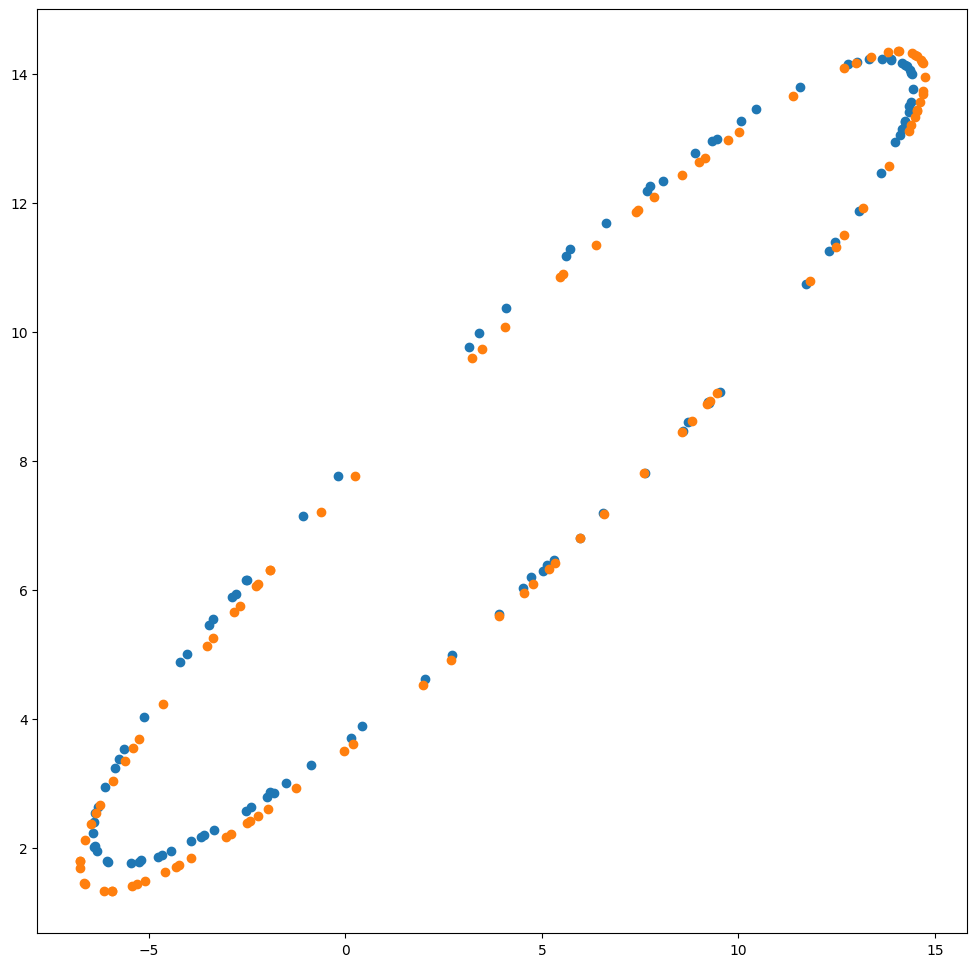

In [8]:
#cx_est,cy_est,a_est,b_est,phi_est = optimizer.vertices()[0].estimate()
#est_eclipse_xs, est_eclipse_ys = sample_ellipse(cx_est,cy_est,a_est,b_est)

R_init = get_rot_mat_from_angle(init_phi)

est_eclipse_xs = []
est_eclipse_ys = []
for i in range(1,num_points):
    init_angle = init_angles[i]
    
    x_,y_ = R_init @ np.array([init_A * np.cos(init_angle),init_B * np.sin(init_angle)])
    
    est_eclipse_xs.append(init_cx + x_)
    est_eclipse_ys.append(init_cy + y_)

dd = np.array(points).T
plt.scatter(dd[0,:],dd[1,:])
plt.scatter(est_eclipse_xs,est_eclipse_ys)

In [9]:
eclipse: VertexEclipse = VertexEclipse()
eclipse.set_id(0)
eclipse.set_estimate([0,0,1,1,init_phi])  # some initial value for the circle
optimizer.add_vertex(eclipse)

True

In [10]:
# 2. add the points we measured

est_rot = get_rot_mat_from_angle(init_phi)

for i,(point, angle) in enumerate(zip(points,init_angles),1):
        
    theta: VertexTheta = VertexTheta()
    theta.set_id(i)
    theta.set_estimate([angle])
    
    optimizer.add_vertex(theta)

    edge: EdgePointOnEclipse = EdgePointOnEclipse()
    edge.set_information(np.identity(1))
  
    edge.set_vertex(0, eclipse)
    edge.set_vertex(1, theta)

    edge.set_measurement(point)
    # print(f"error: {edge.compute_error()}")
    # print(f"edge slots: {dir(edge)}")
    optimizer.add_edge(edge)

In [11]:
np.identity(1)

array([[1.]])

In [12]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 101
Number of edges: 100


In [13]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(verbose)
optimizer.optimize(max_iterations)

Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
iteration= 0	 chi2= 12653.305262	 time= 0.170807	 cumTime= 0.170807	 edges= 100	 schur= 0	 lambda= 402.039502	 levenbergIter= 7
iteration= 1	 chi2= 8753.705389	 time= 0.0549617	 cumTime= 0.225769	 edges= 100	 schur= 0	 lambda= 134.013167	 levenbergIter= 1
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
iteration= 2	 chi2= 5203.497506	 time= 0.0831885	 cumTime= 0.308957	 edges= 100	 schur= 0	 lambda= 178.684223	 levenbergIter= 2
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
iteration= 3	 chi2= 5026.536437

1600

3.675138716565989 7.7980988042412935 12.01909723523124 1.9791874732903523 210.04821316826366


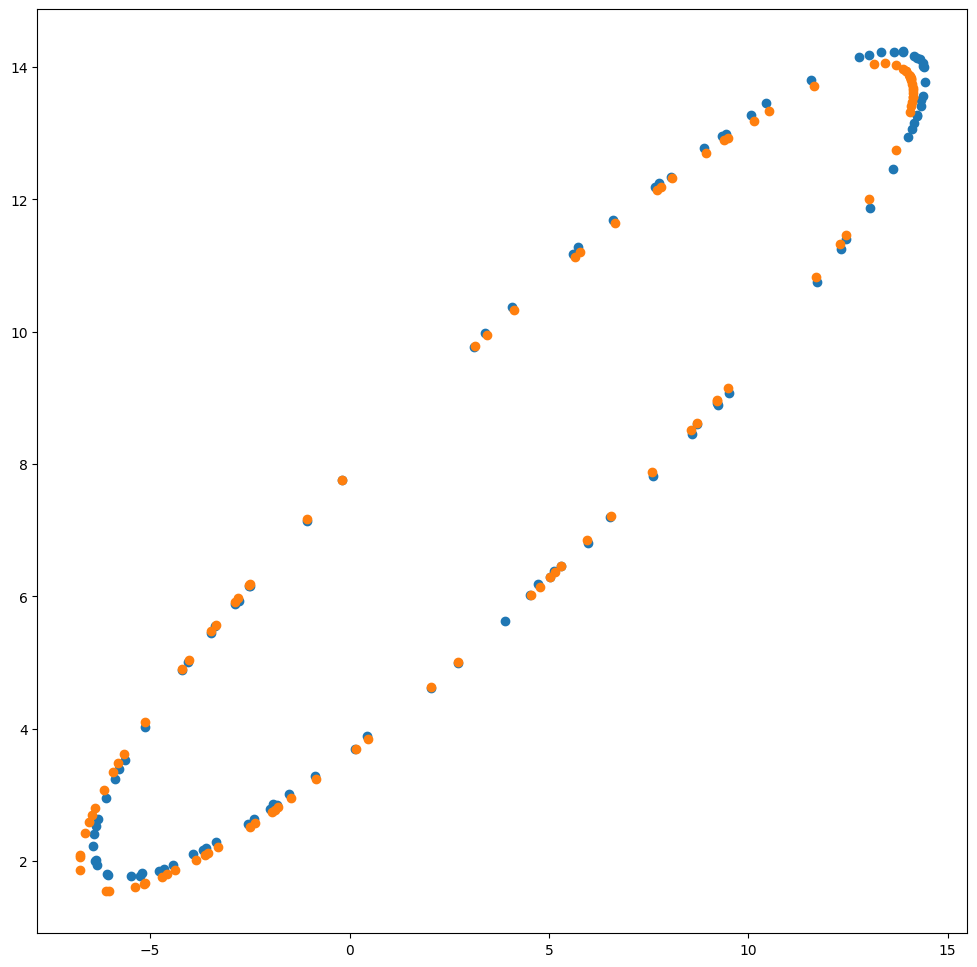

In [14]:
cx_est,cy_est,a_est,b_est,phi_est = optimizer.vertices()[0].estimate()
#est_eclipse_xs, est_eclipse_ys = sample_ellipse(cx_est,cy_est,a_est,b_est)

R_est = get_rot_mat_from_angle(phi_est)

est_eclipse_xs = []
est_eclipse_ys = []
for i in range(1,num_points):
    est_th = optimizer.vertices()[i].estimate()[0]
    
    x_,y_ = R_est @ np.array([a_est * np.cos(est_th),b_est * np.sin(est_th)])
    
    est_eclipse_xs.append(cx_est + x_)
    est_eclipse_ys.append(cy_est + y_)

print(cx_est,cy_est,a_est,b_est,phi_est / np.pi * 180)

dd = np.array(points).T
plt.scatter(dd[0,:],dd[1,:])
plt.scatter(est_eclipse_xs,est_eclipse_ys)